<a href="https://colab.research.google.com/github/jameswilsenach/ClustRepVAE/blob/main/ClustRepVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import imageio
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.utils.data import Subset
to_pil_image = transforms.ToPILImage()
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('./output/generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"./output/output{epoch}.jpg")
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./output/loss.jpg')
    plt.show()

In [10]:
!pwd
!mkdir ./input
!mkdir ./output

/content
mkdir: cannot create directory ‘./input’: File exists
mkdir: cannot create directory ‘./output’: File exists


In [11]:
from tqdm import tqdm
import torch
def final_loss(bce_loss, mu, logvar,beta=5):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD

In [12]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter
    return train_loss

In [13]:
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size,
            stride=2, padding=0
        )

        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)

        # decoder
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )

        for m in self.children():
            if isinstance(m, (nn.Linear,nn.ConvTranspose2d,nn.Conv2d)):
              nn.init.xavier_normal_(m.weight)
              m.bias.data.fill_(0.0)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def forward(self, x):
        # encoding

        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))

        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)

        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)

        z = z.view(-1, 64, 1, 1)

        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))

        return reconstruction, mu, log_var

    def forwardZ(self,mu,logvar):
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)

        z = z.view(-1, 64, 1, 1)

        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

Epoch 1 of 10


938it [01:12, 12.94it/s]                         
157it [00:05, 27.97it/s]                         


Train Loss: 16745.9938
Val Loss: 14007.0679
Epoch 2 of 10


938it [00:52, 17.87it/s]
157it [00:05, 30.61it/s]                         


Train Loss: 13713.9990
Val Loss: 13445.8755
Epoch 3 of 10


938it [00:56, 16.74it/s]                         
157it [00:04, 33.98it/s]                         


Train Loss: 13448.3565
Val Loss: 13289.7155
Epoch 4 of 10


938it [00:54, 17.07it/s]                         
157it [00:05, 27.46it/s]


Train Loss: 13330.1407
Val Loss: 13166.9473
Epoch 5 of 10


938it [00:53, 17.60it/s]                         
157it [00:04, 33.31it/s]                         


Train Loss: 13255.5764
Val Loss: 13169.3897
Epoch 6 of 10


938it [00:53, 17.61it/s]                         
157it [00:05, 27.73it/s]                         


Train Loss: 13203.3845
Val Loss: 13113.9565
Epoch 7 of 10


938it [00:53, 17.61it/s]                         
157it [00:04, 33.59it/s]                         


Train Loss: 13160.3556
Val Loss: 13039.6485
Epoch 8 of 10


938it [00:53, 17.65it/s]                         
157it [00:05, 27.64it/s]                         


Train Loss: 13131.2397
Val Loss: 12999.2645
Epoch 9 of 10


938it [00:55, 17.00it/s]                         
157it [00:04, 33.82it/s]                         


Train Loss: 13100.3470
Val Loss: 13020.0887
Epoch 10 of 10


938it [00:53, 17.47it/s]                         
157it [00:05, 30.43it/s]                         


Train Loss: 13077.6970
Val Loss: 12998.4381


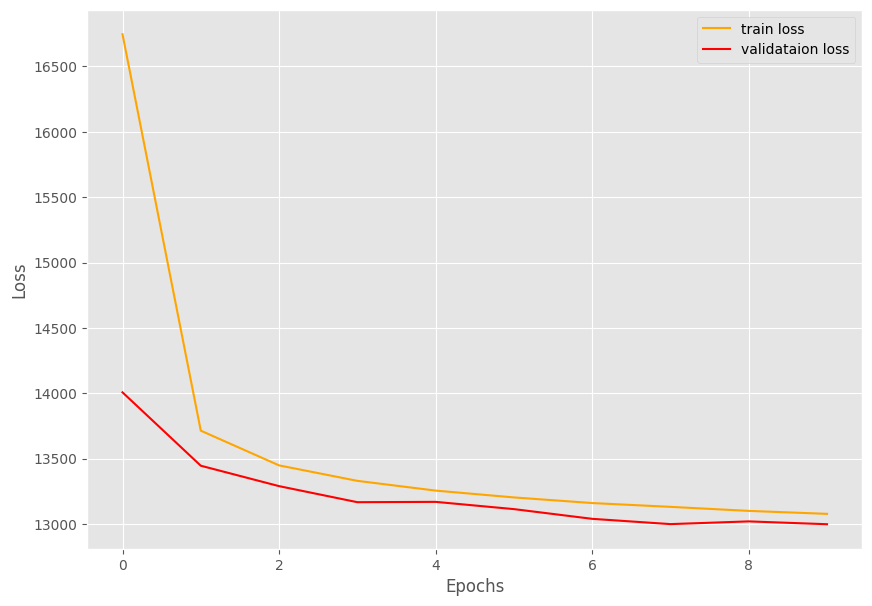

TRAINING COMPLETE


In [15]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 10
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='./input', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='./input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

    # save the reconstructions as a .gif file
image_to_vid(grid_images)
# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')

In [16]:
dataset = testset
dataloader = DataLoader(
    dataset, batch_size=dataset.data.numpy().shape[0], shuffle=False
)
model.eval()
for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
    data= data[0]
    data = data.to(device)
    _, mu, logvar = model(data)

100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


In [17]:
mu = mu.cpu().data.numpy()
logvar = logvar.cpu().data.numpy()

In [18]:
muvar = np.concatenate((logvar,mu),1)

In [19]:
muvar.shape

(10000, 32)

In [20]:
pwcorrmuvar = np.corrcoef(muvar)

In [21]:
divs = 10
subs = np.arange(0,len(muvar),divs)
muvarsub = muvar[subs,:]

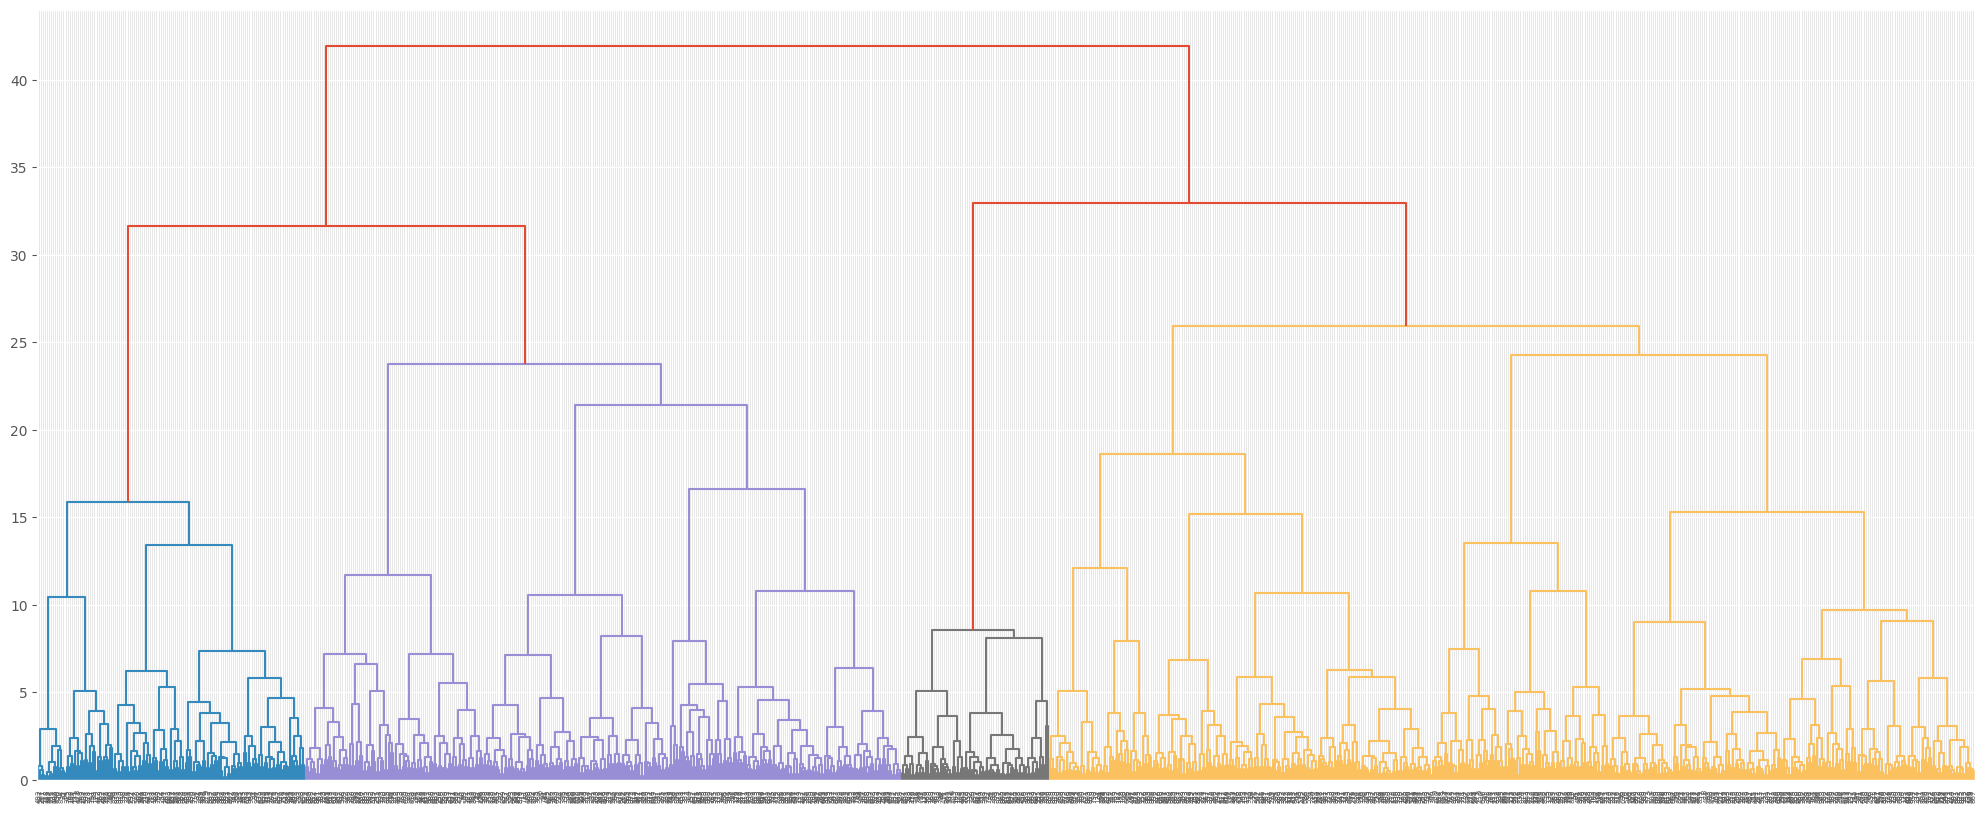

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform,pdist
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pw = pdist(muvarsub,metric='euclidean')
Z = linkage(pw, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [65]:
clusters = fcluster(Z,10,'distance')

In [66]:
print(clusters)
print(np.sum(clusters==1))

[18  9 21  2 12  7 18 18 21  4 22 16 10  7  7 21 22 21 12 13  6 22 21  4
 16 19 17  3  6 22  5  4 12 12  4  1 22 18  9  5  6 18 14 12 11 16 21 17
 12  9  3 20 17 21 16 19 21 16 17  4  7  8  8 21  1  7 22 14  7  6  1 17
  3 21 21  8 21 22  3 12 16 10  7  4 13 12  7  7 20  2  2 22 12  5 16 20
 21 16  6  6 17 22  3 12 12  4 22  3 22 21 19 18 17 22 22  4 22 10  1 16
 17  6  9 22 13  7 12 21 12  2 22  2 17 19 16 12 12 16 21 11  7  6  7  1
 14 22 16 17 10  4 12 16 14 19 18 15 17  9 14  8  2 11  6 12 22  8 20 15
 14  2  9 18 22 16 17 19 12 20 12 10  5  3 12 12  4 19  2  9 22  6 13  2
 21  5 15 18 10  3 22  7  7  1  2 16 11 10 11 21 17 21 16  6 22 22 22 16
  7 22  3  8  5  7 19  4 18 21  6 20  2 18  3 21 21 22 22  5 22 22 22  6
  3  8 22 16 22 16 16 10 20 20  6 12 16 21  3 17  4 21  7 12 10 10  8 22
 17 17  8  3 22  2 18 18 21  5 21 16 21 10  6 17 10 16 19 22  4  4 16 21
 12 20 22  6 22 12  6 12 10  3  7 10  7  3  9 21 18 12 12 12  4 11  3  2
  6  8  8  2 21  9  6 21 22  8 15  1 16  5 10 22 19

In [67]:
testsub = Subset(dataset,subs)

In [68]:
clustset = Subset(testsub,np.arange(len(clusters))[clusters==1])

In [69]:
len(clustset)

15

In [70]:
clustloader = DataLoader(
    clustset, batch_size=len(clustset), shuffle=False
)
with torch.no_grad():
    for i, data in tqdm(enumerate(clustloader), total=int(len(clustset)/clustloader.batch_size)):
        data= data[0]
        data = data.to(device)
        _, muclust, logvarclust = model(data)

100%|██████████| 1/1 [00:00<00:00, 50.09it/s]


In [71]:
clustmean = np.mean(muclust.cpu().data.numpy(),axis=0)

In [72]:
# clustlogvar = np.log(np.sum(np.exp(logvarclust.cpu().numpy()),axis=0)/len(clustset)**2)
# clustlogvar = np.log(np.sum(np.exp(logvarclust.cpu().numpy()),axis=0)/len(clustset))
# clustlogvar = logvarclust.cpu().numpy().mean(axis=0)
varcpu = np.exp(logvarclust.cpu().data.numpy())
n = len(varcpu)
clustlogvar = np.log(np.sum(varcpu+muclust.cpu().data.numpy()**2,axis=0)/n-np.sum(muclust.cpu().data.numpy(),axis=0)**2/n**2)

In [73]:
clustlogvar

array([-1.69999707e+00, -5.37945749e-03, -1.05507064e+00, -2.21330300e-03,
       -1.07083013e-02, -1.55878282e-04,  8.24945571e-04, -1.11971386e-02,
       -6.69107132e-04, -2.61118722e+00, -1.43352544e+00,  3.29950918e-03,
        1.25161642e-02,  1.16651105e-02, -2.08739527e-02, -1.16094232e+00],
      dtype=float32)

In [88]:
ind = 0
logvarclust.cpu().numpy()[ind,:]

array([-2.59819055e+00, -4.54297662e-03, -1.52693450e+00, -2.83529563e-03,
       -7.51155894e-03,  1.81960966e-03, -1.26002356e-04, -1.36191305e-02,
        2.03412026e-04, -3.62013888e+00, -2.50727224e+00,  2.25862511e-03,
        1.18858898e-02,  1.04946392e-02, -2.18286235e-02, -1.71413422e+00],
      dtype=float32)

In [89]:
clustmean

array([-8.8874394e-01,  4.3099534e-02, -3.7725601e-02,  9.3502253e-03,
       -8.6796973e-03,  8.5272472e-03, -9.1302926e-03,  6.1680051e-03,
        8.7741120e-03, -5.8191895e-01, -1.9796401e+00,  7.7364719e-05,
       -1.3465654e-03, -3.0758507e-03,  1.4254895e-02,  2.0110279e-02],
      dtype=float32)

In [90]:
muclust.cpu().numpy()[ind,:]

array([-5.96300185e-01,  3.46833579e-02,  1.67652875e-01,  1.26716979e-02,
       -1.10656926e-02,  7.93652982e-03, -6.05435856e-03,  9.39640775e-03,
        1.55496038e-02, -3.48468095e-01, -2.03439164e+00, -2.39015184e-03,
        1.02945790e-03, -4.29329649e-03,  1.54716345e-02,  1.07435964e-01],
      dtype=float32)

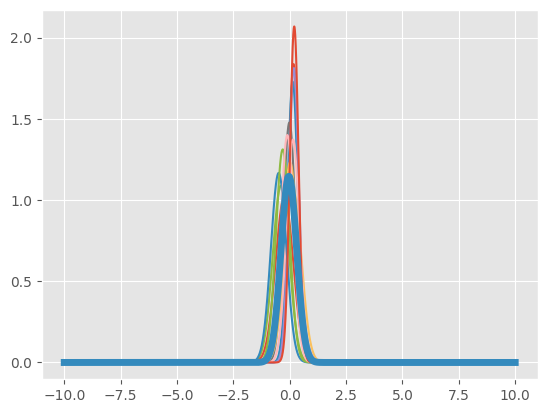

In [98]:
from scipy.stats import norm
dim = 2
x_axis = np.arange(-10, 10, 0.0001)
for i in range(np.sum(clusters==1)):
  plt.plot(x_axis, norm.pdf(x_axis,muclust.cpu().numpy()[i,dim],np.exp(logvarclust.cpu().numpy()[i,dim])))
plt.plot(x_axis, norm.pdf(x_axis,clustmean[dim],np.exp(clustlogvar[dim])),lw=5)

In [86]:
b=10
tensmu = torch.from_numpy(clustmean).float().to(device).unsqueeze(0).repeat(b,1)
tenslogvar = torch.from_numpy(clustlogvar).float().to(device).unsqueeze(0).repeat(b,1)

print(tensmu.shape)

z = model.reparameterize(tensmu, tenslogvar)
z = model.fc2(z)

z = z.view(-1, 64, 1, 1)

# decoding
x = F.relu(model.dec1(z))
x = F.relu(model.dec2(x))
x = F.relu(model.dec3(x))
reconstruction = torch.sigmoid(model.dec4(x))

torch.Size([10, 16])


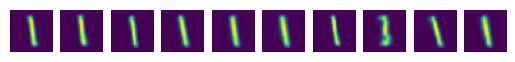

In [87]:
fig,ax=plt.subplots(ncols=b)
for i,a in enumerate(ax):
  a.imshow(np.squeeze(reconstruction.cpu().detach().numpy()[i]))
  a.axis('off')

In [51]:
from sklearn.manifold import Isomap

y = Isomap(n_components = 2,metric="euclidean").fit_transform(muvarsub)

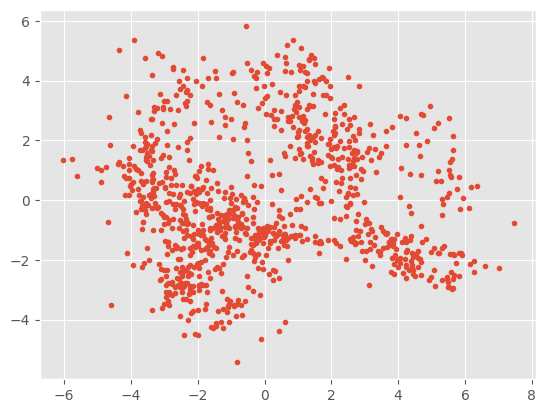

In [52]:
plt.plot(y[:,0],y[:,1],'.')